In [2]:
# Install the fredapi package silently
!pip install fredapi > /dev/null

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

# Set matplotlib style
plt.style.use('fivethirtyeight')

# Set pandas option to display maximum columns
pd.set_option('display.max_columns', 500)

# Get the color palette for plots
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Import the Fred class from the fredapi package
from fredapi import Fred

# Retrieve the API key from a secret
from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

# Retrieve the Fred API key from the secrets
fred_key = secrets.get_secret('fred-api')

# Initialize the Fred object with the API key
fred = Fred(api_key=fred_key)

In [3]:
# Search for unemployment rate data for states from the FRED database
state_unemployment_data = fred.search('unemployment rate state', filter=('frequency', 'Monthly'))

# Filter the search results to include only seasonally adjusted data in percentage units
state_unemployment_data = state_unemployment_data.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

# Further filter the results to include only unemployment rate data
state_unemployment_data = state_unemployment_data.loc[state_unemployment_data['title'].str.contains('Unemployment Rate')]

# Initialize an empty list to store unemployment rate dataframes for each state
state_unemployment_dfs = []

# Retrieve unemployment rate data for each state and store it in a list
for series_id in state_unemployment_data.index:
    state_unemployment_series = fred.get_series(series_id)
    state_unemployment_df = state_unemployment_series.to_frame(name=series_id)
    state_unemployment_dfs.append(state_unemployment_df)
    time.sleep(0.1)  # Pause for a short time to avoid overloading the API

# Concatenate all the retrieved dataframes into a single dataframe
all_state_unemployment_data = pd.concat(state_unemployment_dfs, axis=1)

# Identify and drop columns with IDs longer than 4 characters
columns_to_drop = [col for col in all_state_unemployment_data.columns if len(col) > 4]
all_state_unemployment_data = all_state_unemployment_data.drop(columns=columns_to_drop, axis=1)

# Create a copy of the dataframe for further processing
processed_state_unemployment_data = all_state_unemployment_data.copy()

# Drop rows with missing values
processed_state_unemployment_data = processed_state_unemployment_data.dropna()

# Create a dictionary mapping series IDs to state names
id_to_state_mapping = state_unemployment_data['title'].str.replace('Unemployment Rate in ', '').to_dict()

# Rename columns of the dataframe using the state names
processed_state_unemployment_data.columns = [id_to_state_mapping[col] for col in processed_state_unemployment_data.columns]

# Plot the unemployment rates for each state using Plotly Express
px.line(processed_state_unemployment_data)

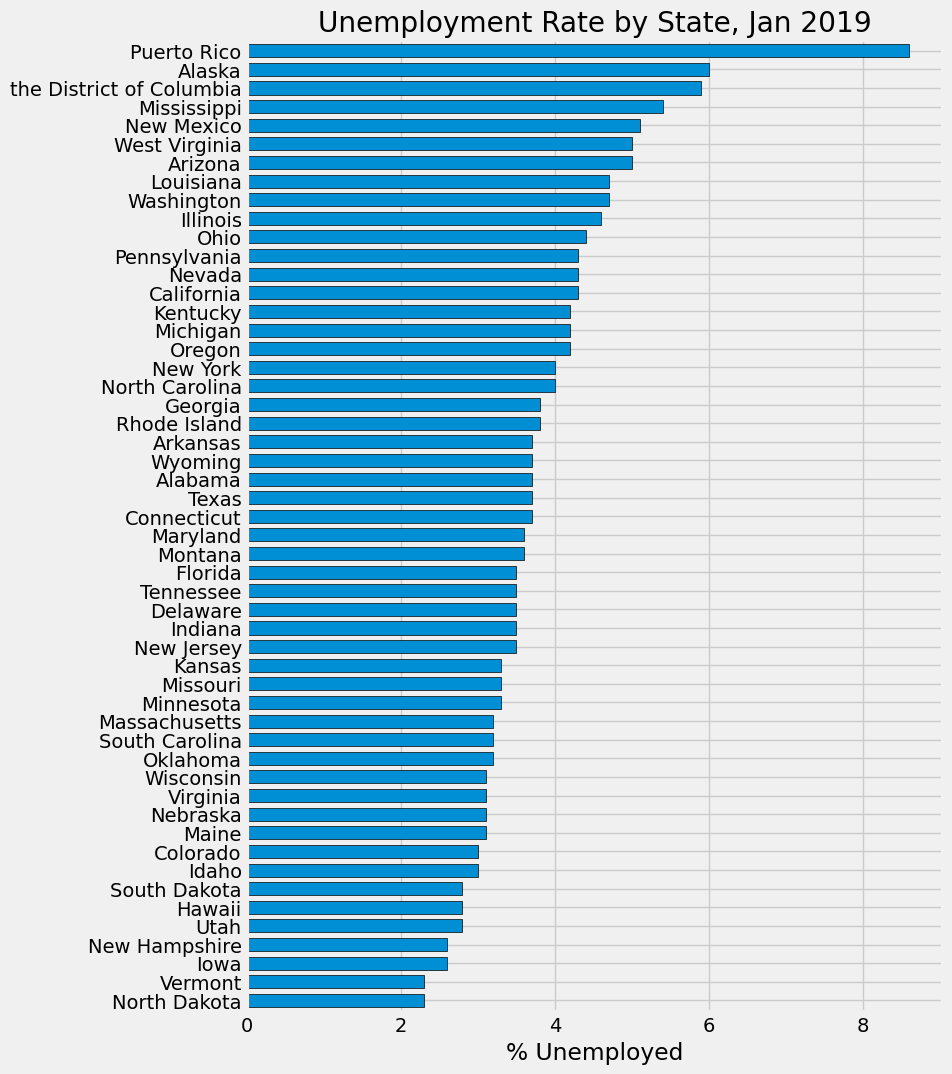

In [7]:
ax = processed_state_unemployment_data.loc[processed_state_unemployment_data.index == '2019-01-01'].T \
    .sort_values('2019-01-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, Jan 2019')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

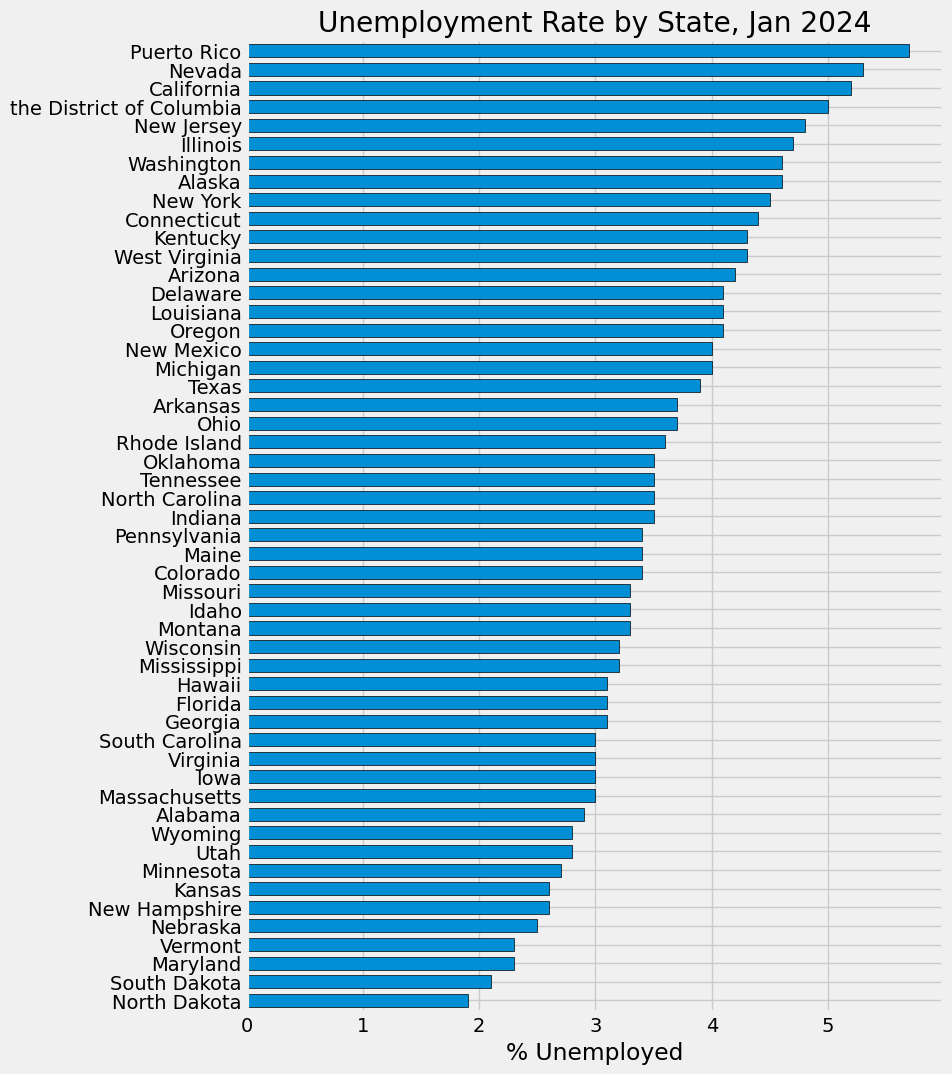

In [8]:
ax = processed_state_unemployment_data.loc[processed_state_unemployment_data.index == '2024-01-01'].T \
    .sort_values('2024-01-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, Jan 2024')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

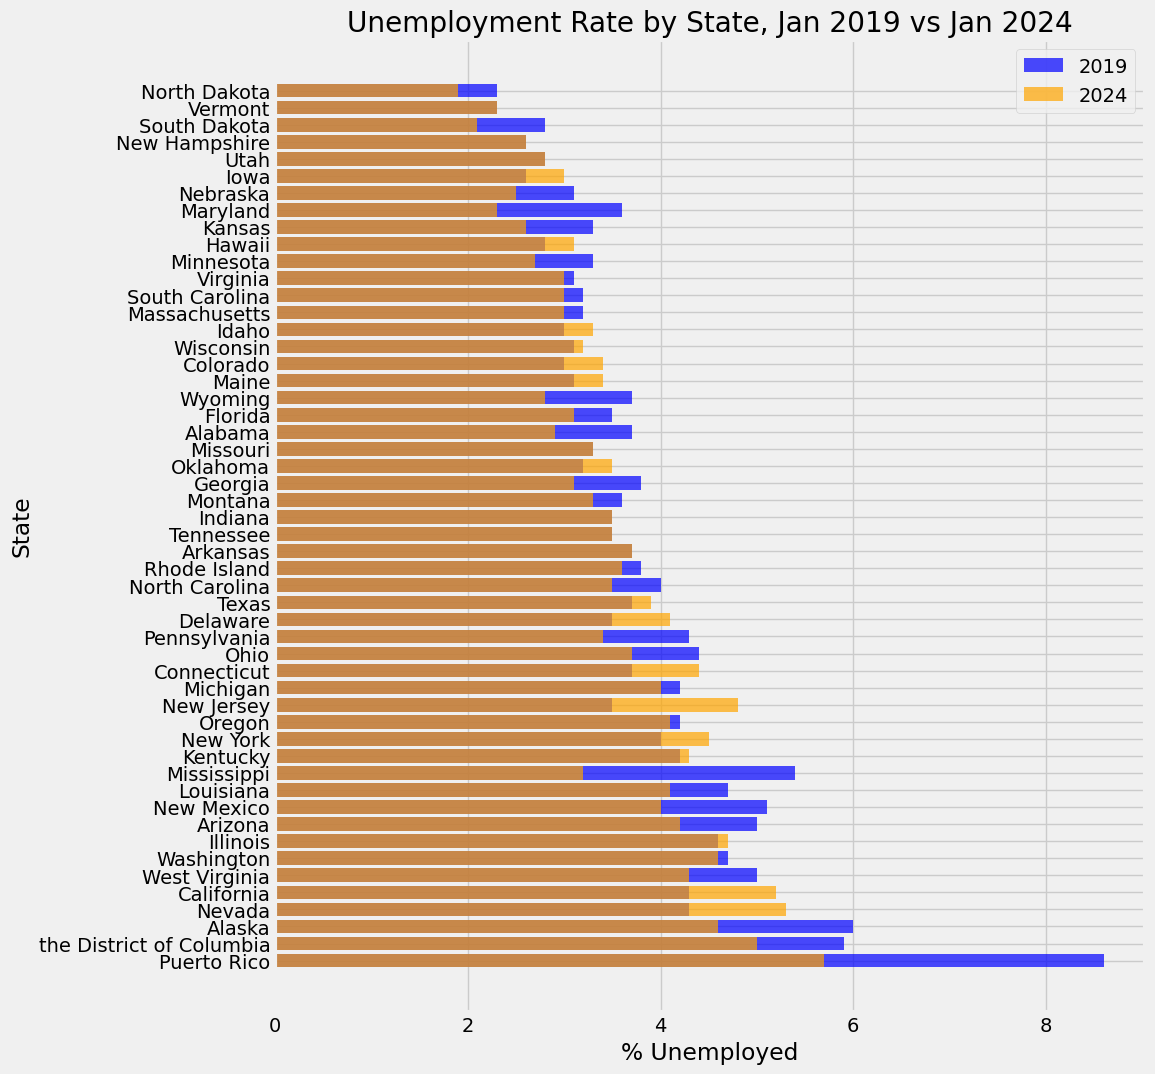

In [11]:
import matplotlib.pyplot as plt

# Get the data for 2019 and 2024
unemployment_data_2019 = processed_state_unemployment_data.loc[processed_state_unemployment_data.index == '2019-01-01'].T
unemployment_data_2024 = processed_state_unemployment_data.loc[processed_state_unemployment_data.index == '2024-01-01'].T

# Combine the data and calculate the average unemployment rate
combined_data = unemployment_data_2019.merge(unemployment_data_2024, left_index=True, right_index=True, suffixes=('_2019', '_2024'))
combined_data['average'] = (combined_data.iloc[:, 0] + combined_data.iloc[:, 1]) / 2

# Sort the combined data by the average unemployment rate
combined_data = combined_data.sort_values('average', ascending=False)

# Plot the bars for 2019
plt.barh(combined_data.index, combined_data.iloc[:, 0], color='blue', alpha=0.7, label='2019')

# Plot the bars for 2024 with the same color
plt.barh(combined_data.index, combined_data.iloc[:, 1], color='orange', alpha=0.7, label='2024')

# Set plot title and labels
plt.title('Unemployment Rate by State, Jan 2019 vs Jan 2024')
plt.xlabel('% Unemployed')
plt.ylabel('State')

# Show legend
plt.legend()

# Set figure size
plt.gcf().set_size_inches(10, 12)

# Show the plot
plt.show()

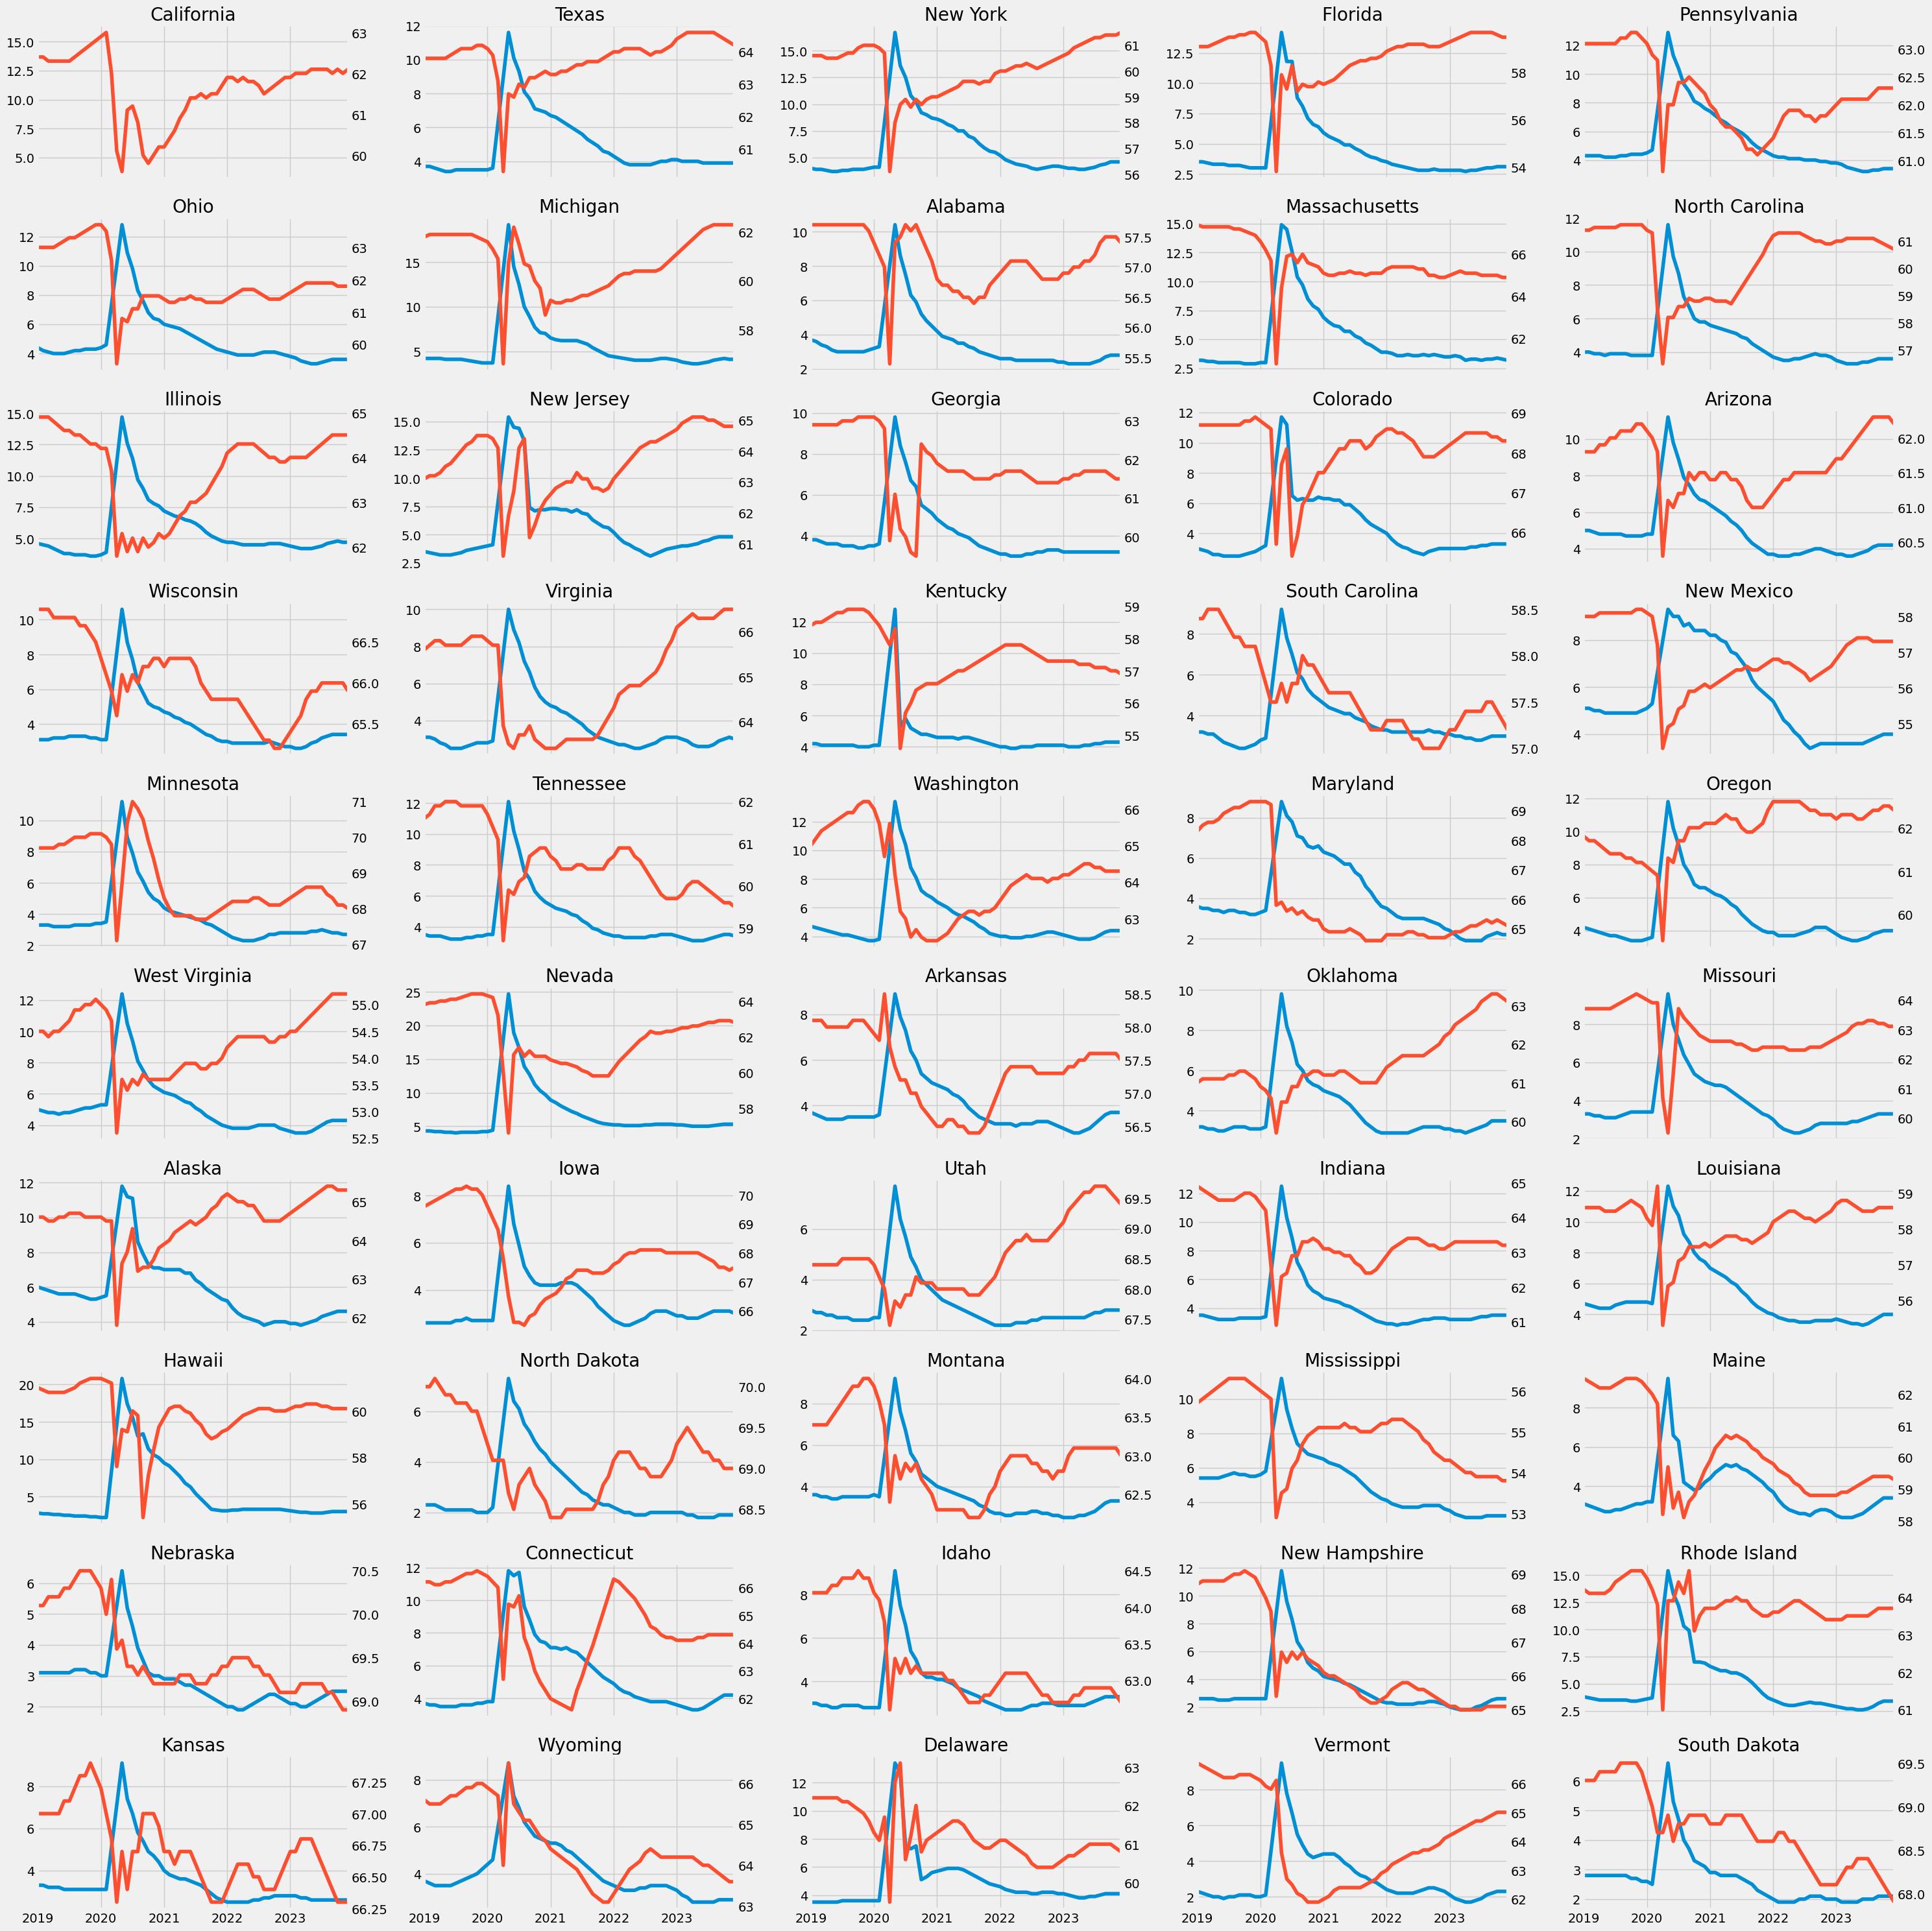

In [13]:
# Get participation rate data for states
participation_df = fred.search('participation rate state', filter=('frequency','Monthly')) 
participation_df = participation_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

# Create a dictionary mapping IDs to state names
part_id_to_state = participation_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

# Get participation rate data for all states
all_participation_results = []

for part_id in participation_df.index:
    part_results = fred.get_series(part_id)
    part_results = part_results.to_frame(name=part_id)
    all_participation_results.append(part_results)
    time.sleep(0.1) # To avoid getting blocked

participation_states = pd.concat(all_participation_results, axis=1)
participation_states.columns = [part_id_to_state[part_c] for part_c in participation_states.columns]

# Rename states for consistency
processed_state_unemployment_data = processed_state_unemployment_data.rename(columns={'the District of Columbia':'District Of Columbia'})

# Create subplots for each state
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in processed_state_unemployment_data.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    processed_state_unemployment_data.query('index >= 2019 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    participation_states.query('index >= 2019 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

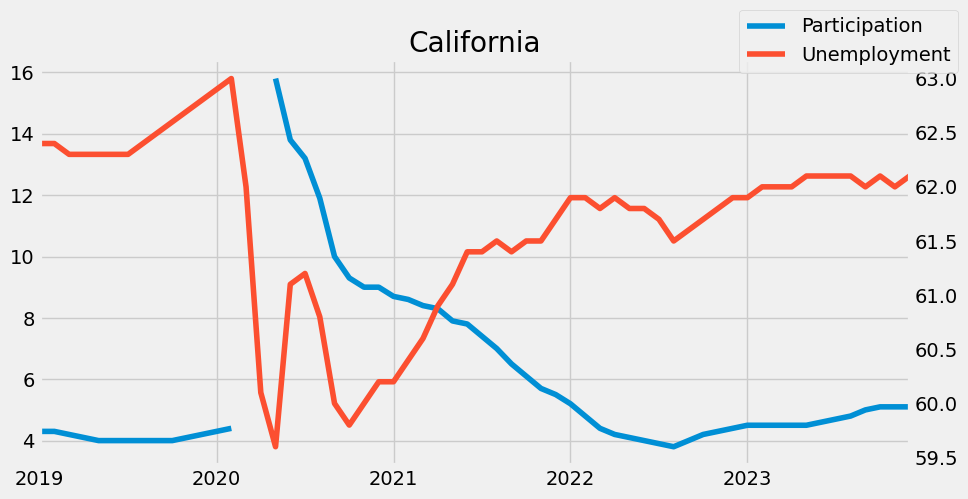

In [14]:
selected_state = 'California'

# Create subplots
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()

# Resample the data to monthly frequency
processed_state_unemployment_data_resampled = processed_state_unemployment_data.asfreq('MS')

# Plot participation rate and unemployment rate for the selected state
participation_line = processed_state_unemployment_data_resampled.query('index >= 2019 and index < 2024')[selected_state] \
    .plot(ax=ax, label='Participation')
unemployment_line = participation_states.dropna().query('index >= 2019 and index < 2024')[selected_state] \
    .plot(ax=ax2, label='Unemployment', color=color_pal[1])

# Remove grid from ax2
ax2.grid(False)

# Set title
ax.set_title(selected_state)

# Add legend
fig.legend(labels=['Participation','Unemployment'])

# Show plot
plt.show()

In [15]:
from datetime import date
import pandas_datareader.data as web
import numpy as np
import seaborn as sns

# Define the reporting period
report_start_date = date.fromisoformat('2010-01-01')
report_end_date = date.today()

# Retrieve real GDP data from FRED
real_gdp_data = web.get_data_fred('GDPC1', start=report_start_date, end=report_end_date)

# Calculate quarterly growth rate expressed as annual growth
real_gdp_quarterly = ((real_gdp_data / real_gdp_data.shift(1)).pow(4) - 1)

# Calculate rolling 4-quarter mean and percentage change
real_gdp = real_gdp_data.rolling(4).mean().pct_change(4, fill_method='bfill')

# Rename columns and add quarterly growth rate expressed as annual growth
real_gdp.rename(columns={'GDPC1': 'Real GDP'}, inplace=True)
real_gdp['Real GDP over quarter at annual rate'] = real_gdp_quarterly
real_gdp.dropna(inplace=True)

# Set up seaborn color palette
cm = sns.color_palette('Blues', as_cmap=True)

# Format and style the dataframe
IDX_FORMAT = '{:%Y-%m}'
styled_real_gdp = real_gdp.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}') \
    .set_properties(subset=real_gdp.columns, **{'width': '200px'}) \
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}]) \
    .background_gradient(cmap=cm)

styled_real_gdp

/tmp/ipykernel_33/1588297516.py:17: FutureWarning:

The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



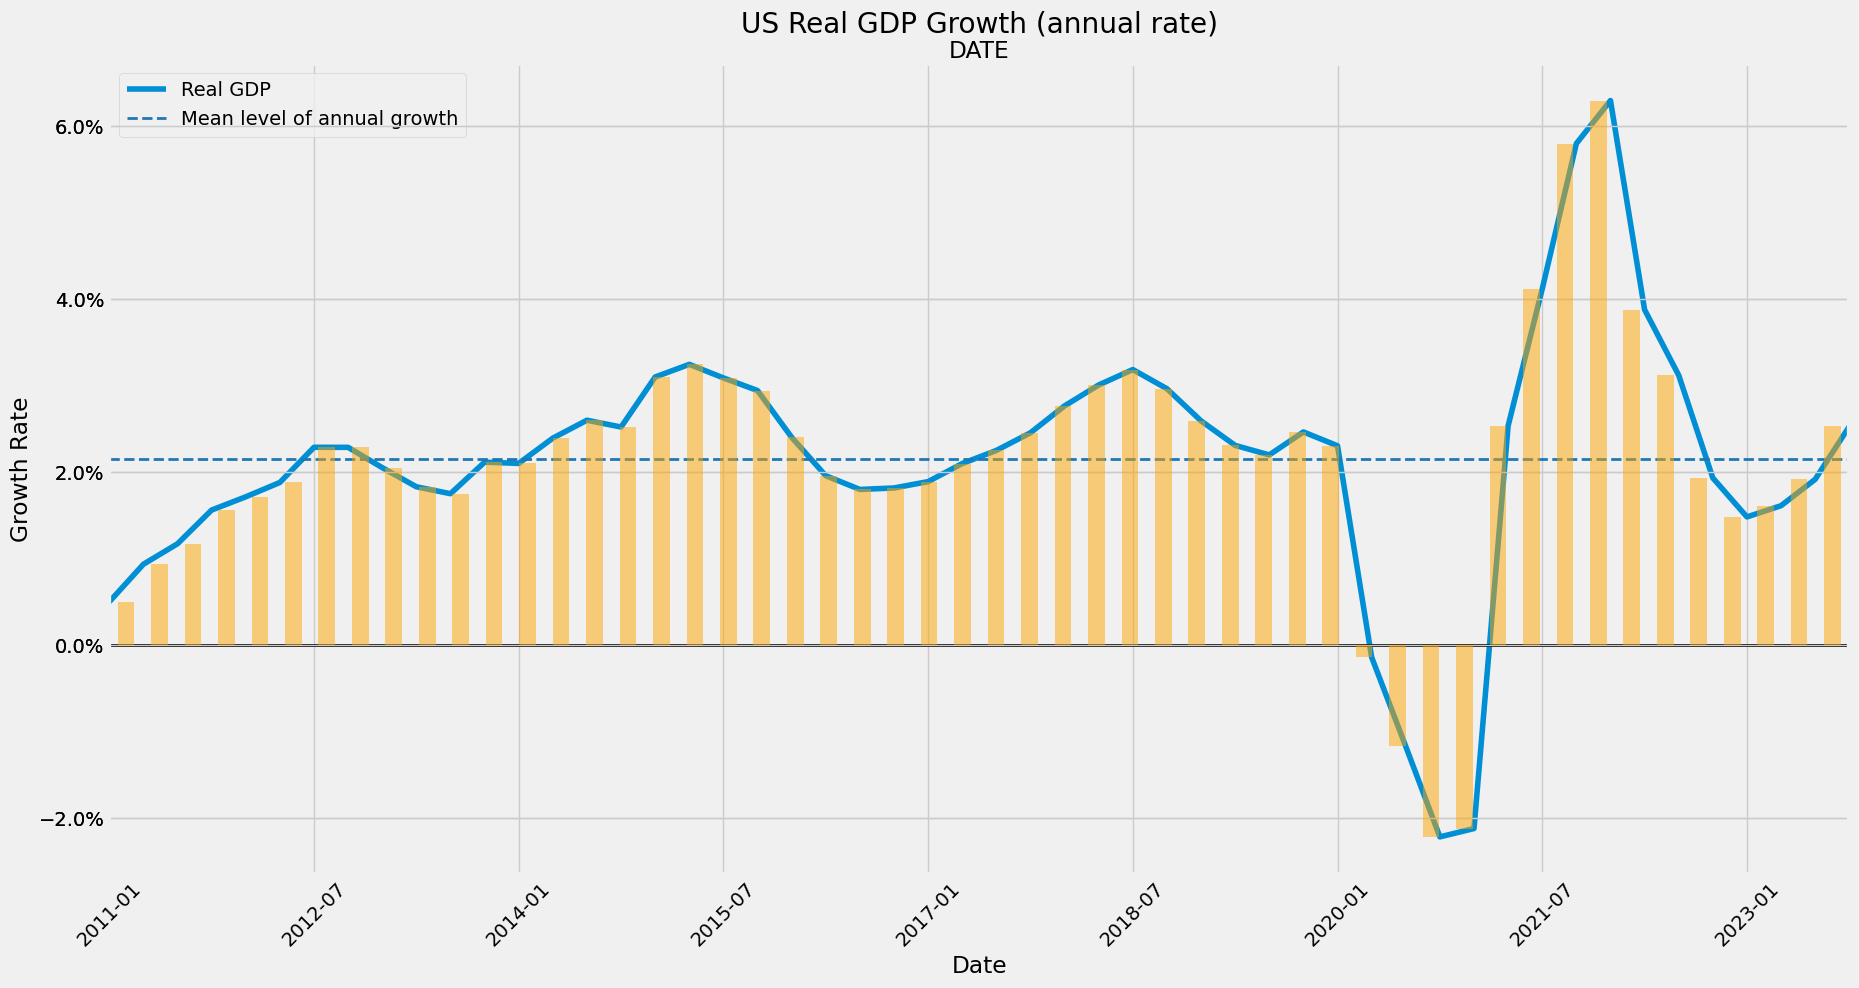

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plotting US Real GDP Growth (annual rate)
fig, ax = plt.subplots(figsize=(20, 10))
real_gdp_growth = real_gdp.iloc[:, 0]

# Plot line graph with grid
real_gdp_growth.plot(ax=ax, grid=True, title='US Real GDP Growth (annual rate)', rot=45)

# Customize x-axis ticks and labels
ax.set_xticks(real_gdp.index[::6])
ax.set_xticklabels(map('{:%Y-%m}'.format, real_gdp.index[::6]))

# Add horizontal lines for mean growth
mean_growth = real_gdp_growth.mean()
ax.axhline(y=0, lw=2, c='k')
ax.axhline(y=mean_growth, lw=2, ls='--', c='#1f77b4', label='Mean level of annual growth')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Plot bar graph on secondary x-axis
ax2 = ax.twiny()
real_gdp_growth.plot.bar(ax=ax2, color='orange', alpha=0.5)

# Remove secondary x-axis ticks
ax2.xaxis.set_major_locator(ticker.NullLocator())

# Set labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Growth Rate')
ax.legend()

# Show plot
plt.show()

In [17]:
print(f'Mean level of real GDP growth rate since {real_gdp.index[0]:%Y-%m-%d}: {real_gdp.iloc[:,0].mean():.2%}')

Mean level of real GDP growth rate since 2011-01-01: 2.16%


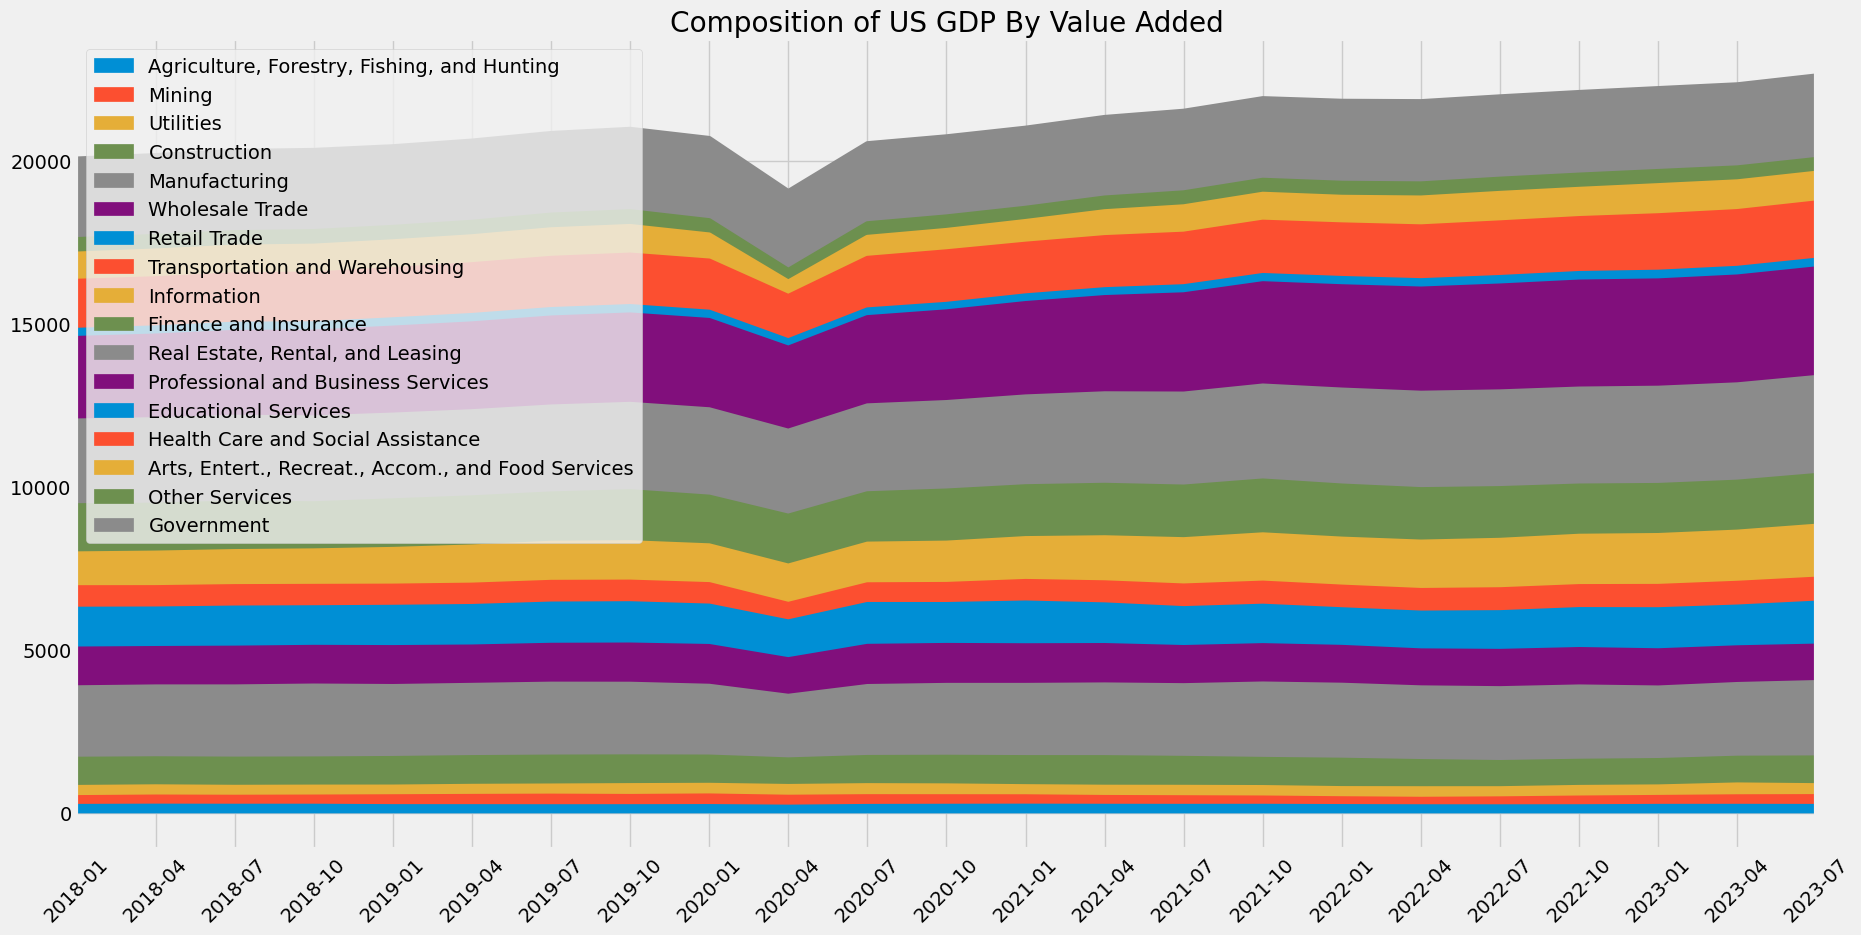

In [18]:
# Import necessary libraries
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

# Define start and end dates for data retrieval
report_start = date.fromisoformat('2010-01-01')
report_end = date.today()

# Fetch GDP component data from FRED
gdp_components = web.get_data_fred(['RVAAFH', 'RVAM', 'RVAU', 'RVAC', 'RVAMA', 'RVAW', 'RVAR', 'RVAT',
                                    'RVAI', 'RVAFI', 'RVARL', 'RVAPBS', 'RVAES', 'RVAHCSA', 'RVAAERAF',
                                    'RVAOSEG', 'RVAG', 'RVAAI'], start=report_start, end=report_end)

# Define column names for GDP components
GDP_COLUMN_NAMES = {
    'RVAAFH': 'Agriculture, Forestry, Fishing, and Hunting',
    'RVAM': 'Mining',
    'RVAU': 'Utilities',
    'RVAC': 'Construction',
    'RVAMA': 'Manufacturing',
    'RVAW': 'Wholesale Trade',
    'RVAR': 'Retail Trade',
    'RVAT': 'Transportation and Warehousing',
    'RVAI': 'Information',
    'RVAFI': 'Finance and Insurance',
    'RVARL': 'Real Estate, Rental, and Leasing',
    'RVAPBS': 'Professional and Business Services',
    'RVAES': 'Educational Services',
    'RVAHCSA': 'Health Care and Social Assistance',
    'RVAAERAF': 'Arts, Entert., Recreat., Accom., and Food Services',
    'RVAOSEG': 'Other Services',
    'RVAG': 'Government',
    'RVAAI': 'Other Industries'
}

# Rename columns of the DataFrame
gdp_components.rename(columns=GDP_COLUMN_NAMES, inplace=True)

# Extract the total GDP
gdp_total = gdp_components.iloc[:, -1]
gdp_components = gdp_components.iloc[:, :-1]

# Plot area chart for GDP components
fig, ax = plt.subplots(figsize=(20, 10))
gdp_components.plot.area(ax=ax, grid=True, title='Composition of US GDP By Value Added',
                          xticks=gdp_components.index, xlabel='', rot=45)

# Set x-axis tick labels
_ = ax.set_xticklabels(map('{:%Y-%m}'.format, gdp_components.index))

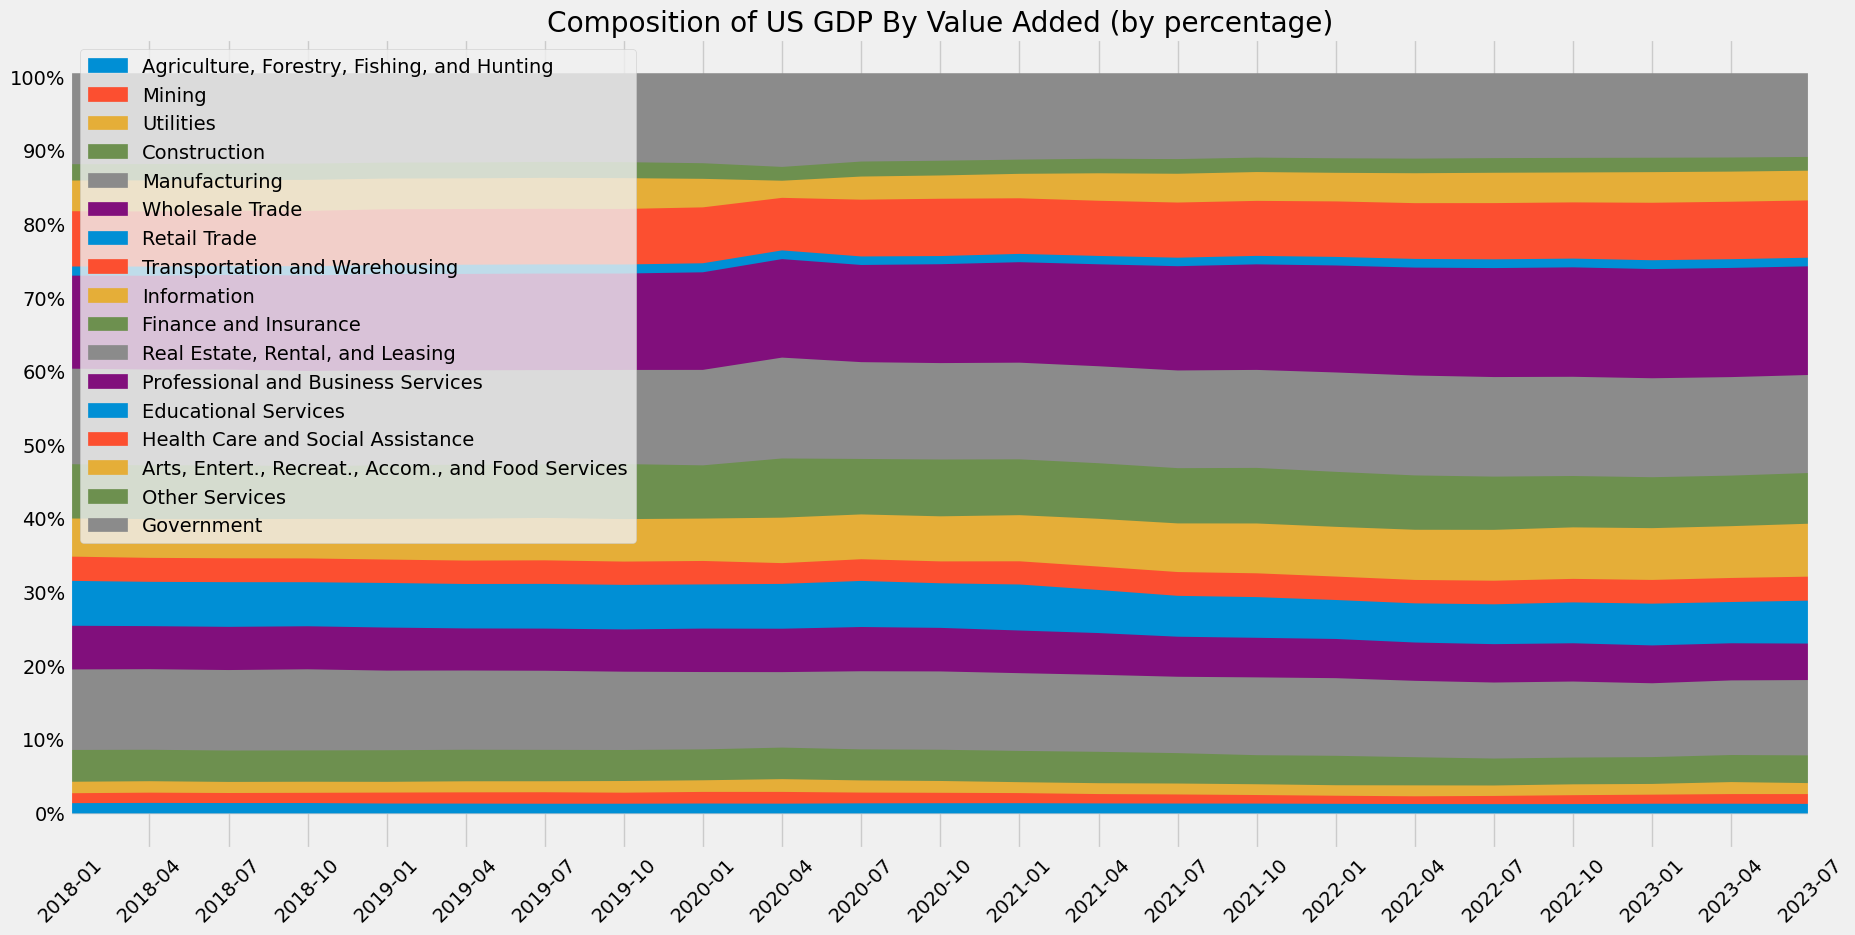

In [19]:
# Calculate the percentage contribution of each GDP component
gdp_components_pct = gdp_components.divide(gdp_components.sum(axis=1), axis=0)

# Plot area chart for GDP components by percentage
fig, ax = plt.subplots(figsize=(20, 10))
gdp_components_pct.plot.area(ax=ax, grid=True, title='Composition of US GDP By Value Added (by percentage)',
                              xticks=gdp_components_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))

# Format y-axis labels as percentages
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Set legend position
ax.legend(loc='upper left')

# Set x-axis tick labels
_ = ax.set_xticklabels(map('{:%Y-%m}'.format, gdp_components_pct.index))

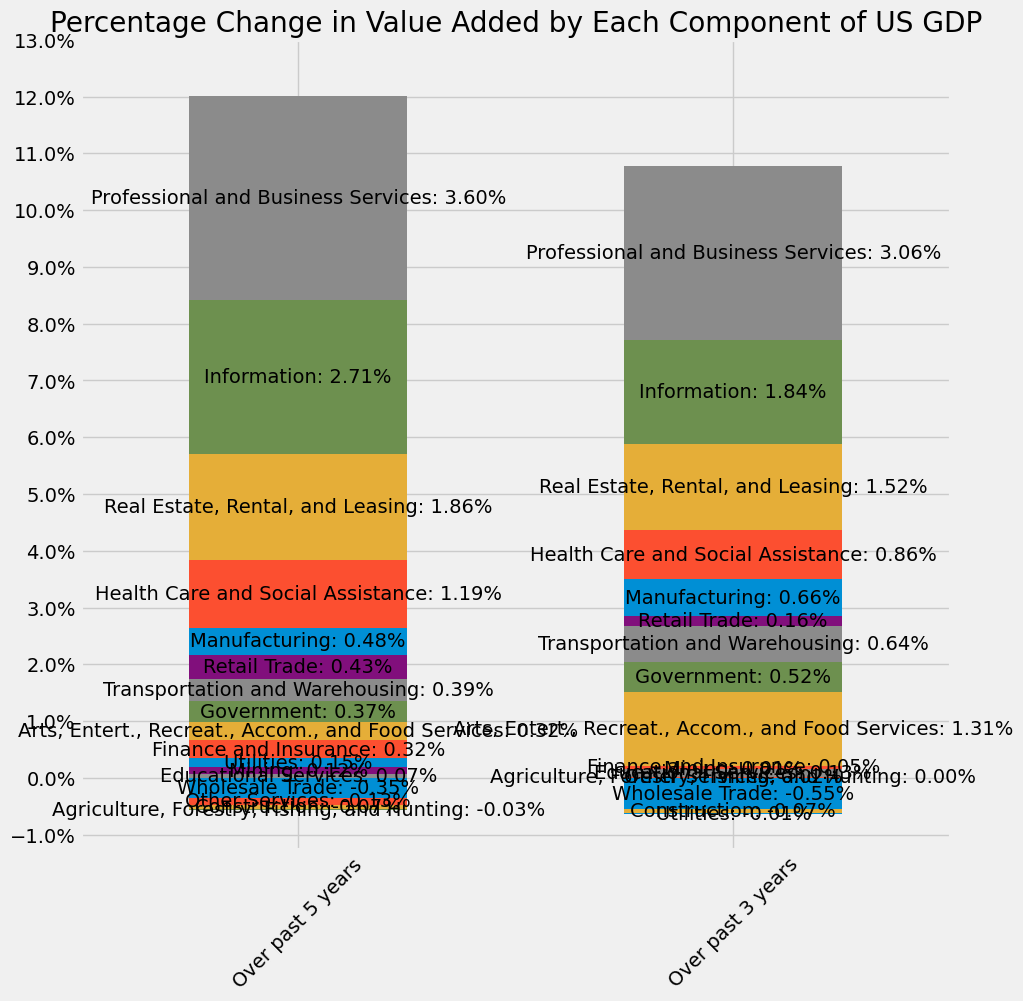

In [21]:
GRAPH_TITLE_GDP_COMPONENTS = 'Composition of US GDP By Value Added'
GRAPH_TITLE_GDP_COMPONENTS_PCT_CHG = 'Percentage Change in Value Added by Each Component of US GDP'

# Define periods for analysis
periods = [5, 3]

# Calculate percentage change in total GDP over specified periods
gdp_total_pct_chg = pd.DataFrame(
    [gdp_total.pct_change(4 * period).iloc[-1] for period in periods],
    index=['Over past {:d} years'.format(period) for period in periods],
    columns=['Percentage Change'])

# Calculate percentage change in GDP components relative to total GDP over specified periods
gdp_components_pct_chg = pd.concat(
    [((gdp_components - gdp_components.shift(4 * period)).divide(gdp_total.shift(4 * period), axis=0)).iloc[-1]
     for period in periods],
    axis=1)
gdp_components_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

# Sort the DataFrame by the first column
gdp_components_pct_chg.sort_values(by=gdp_components_pct_chg.columns[0], inplace=True)

# Plot bar chart for percentage change in GDP components
ax = gdp_components_pct_chg.T.plot.bar(figsize=(10, 10), grid=True, title=GRAPH_TITLE_GDP_COMPONENTS_PCT_CHG,
                                       stacked=True, rot=45, yticks=np.arange(-.01, 0.13, .01))

# Format y-axis labels as percentages
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Remove legend
ax.get_legend().remove()

# Add percentage labels to the bars
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

In [22]:
gdp_components_pct_chg.sort_values(by=gdp_components_pct_chg.columns[0], ascending=False).iloc[:5,:1]

Over past 5 years
Professional and Business Services           0.035958
Information                                  0.027106
Real Estate, Rental, and Leasing             0.018618
Health Care and Social Assistance            0.011911
Manufacturing                                0.004759

In [23]:
gdp_components_pct_chg.sort_values(by=gdp_components_pct_chg.columns[1], ascending=False).iloc[:5,1:]

Over past 3 years
Professional and Business Services                           0.030558
Information                                                  0.018380
Real Estate, Rental, and Leasing                             0.015162
Arts, Entert., Recreat., Accom., and Food Services           0.013056
Health Care and Social Assistance                            0.008571

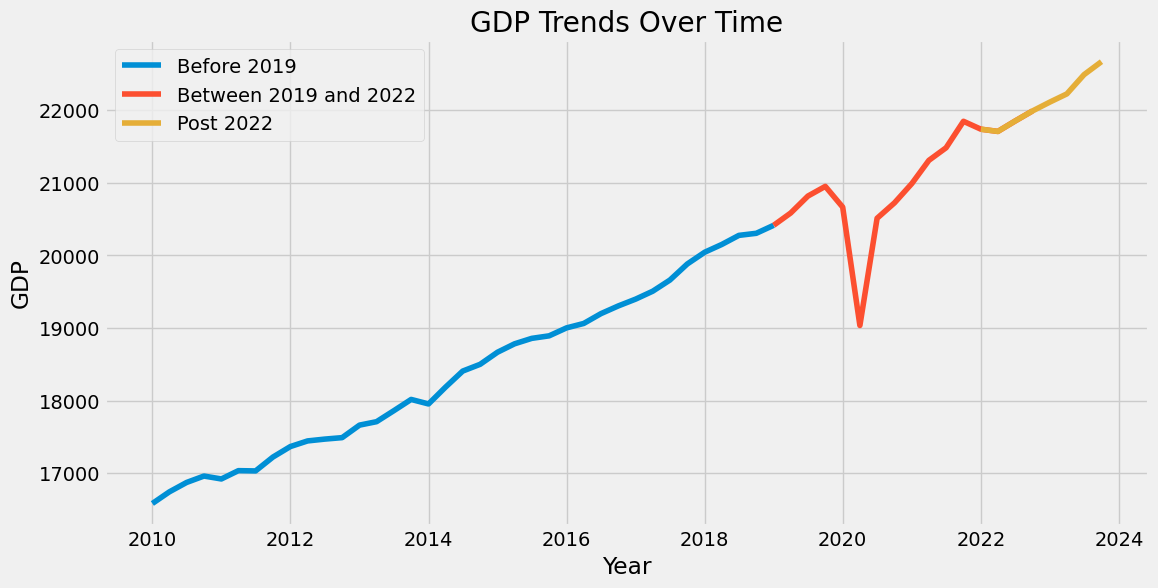

In [24]:
# Import necessary libraries
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt

# Define the sentiments DataFrame (From the Reddit posts)
sentiments = pd.DataFrame({
    'Year': ['Before 2019', 'Between 2019 and 2022', 'Post 2022'],
    'Negative': [60.606061, 55.172414, 77.777778],
    'Positive': [24.242424, 24.137931, 11.111111],
    'Neutral': [15.151515, 20.689655, 11.111111]
})

# Define the periods for GDP data
gdp_periods = {
    'Before 2019': (pd.to_datetime('2010-01-01'), pd.to_datetime('2019-01-01')),
    'Between 2019 and 2022': (pd.to_datetime('2019-01-01'), pd.to_datetime('2022-12-31')),
    'Post 2022': (pd.to_datetime('2022-01-01'), pd.Timestamp.today())
}

# Fetch GDP data for each period
gdp_data = {}
for period, (start_date, end_date) in gdp_periods.items():
    gdp = web.get_data_fred('GDPC1', start=start_date, end=end_date)
    gdp_data[period] = gdp

# Plot GDP trends over time
plt.figure(figsize=(12, 6))
for period, data in gdp_data.items():
    plt.plot(data.index, data['GDPC1'], label=period)
plt.title('GDP Trends Over Time')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Import necessary libraries
import pandas_datareader.data as web
import pandas as pd

# Fetch real GDP data from FRED
real_gdp = web.get_data_fred('GDPC1', start=report_start, end=report_end)

# Create an empty list to store mean GDP data
mean_gdp_data = []

# Iterate through the gdp_data dictionary
for period, data in gdp_data.items():
    # Calculate the mean GDP for the period
    mean_gdp = data['GDPC1'].mean()
    # Append the period name and mean GDP to the list
    mean_gdp_data.append({'Period': period, 'Mean GDP': mean_gdp})

# Create a DataFrame from the list of mean GDP data
mean_gdp_df = pd.DataFrame(mean_gdp_data)

# Print the DataFrame
print(mean_gdp_df)

                  Period      Mean GDP
0            Before 2019  18401.068216
1  Between 2019 and 2022  21038.972438
2              Post 2022  22098.187875


In [32]:
# Merge GDP data with sentiments DataFrame
merged_df = pd.merge(mean_gdp_df, sentiments, left_on='Period', right_on='Year')

# Drop the 'Year' column as it's redundant
merged_df.drop(columns=['Period','Year'], inplace=True)

print(merged_df)

       Mean GDP   Negative   Positive    Neutral
0  18401.068216  60.606061  24.242424  15.151515
1  21038.972438  55.172414  24.137931  20.689655
2  22098.187875  77.777778  11.111111  11.111111


In [36]:
# Pearson Correlation
merged_df_corr = merged_df.corr(method='pearson')
merged_df_corr

Mean GDP  Negative  Positive   Neutral
Mean GDP  1.000000  0.542286 -0.725943 -0.190680
Negative  0.542286  1.000000 -0.971516 -0.928181
Positive -0.725943 -0.971516  1.000000  0.813559
Neutral  -0.190680 -0.928181  0.813559  1.000000

In [34]:
# Spearman Correlation
merged_df_corr = merged_df.corr(method='spearman')
merged_df_corr

Mean GDP  Negative  Positive  Neutral
Mean GDP       1.0       0.5      -1.0     -0.5
Negative       0.5       1.0      -0.5     -1.0
Positive      -1.0      -0.5       1.0      0.5
Neutral       -0.5      -1.0       0.5      1.0

In [37]:
import plotly.express as px

# Create a heatmap figure
fig = px.imshow(merged_df_corr,
                labels=dict(color="Correlation"),
                x=merged_df_corr.columns,
                y=merged_df_corr.index,
                color_continuous_scale='RdBu',
                title='Correlation Matrix GDP v/s Sentiment',
                text_auto=True)

# Update the layout
fig.update_layout(width=800, height=600)

# Show the figure
fig.show()

In [38]:
from datetime import date

report_start = date.fromisoformat('2010-01-01')
report_end = date.today()

real_gdp = web.get_data_fred('GDPC1', start=report_start, end=report_end)

real_gdp_quarterly = ((real_gdp/real_gdp.shift(1)).pow(4)-1)

real_gdp = real_gdp.rolling(4).mean().pct_change(4, fill_method='bfill')

/tmp/ipykernel_33/1400878161.py:10: FutureWarning:

The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [39]:
# Define the date ranges for each interval
before_2019_range = ('2010-01-01', '2019-01-01')
between_2019_2022_range = ('2019-01-01', '2022-12-31')
post_2022_range = ('2022-01-01', '2023-10-01')  # Adjust the end date as needed

# Calculate the mean GDP for each interval
mean_gdp_before_2019 = real_gdp.loc[before_2019_range[0]:before_2019_range[1]].mean()
mean_gdp_between_2019_2022 = real_gdp.loc[between_2019_2022_range[0]:between_2019_2022_range[1]].mean()
mean_gdp_post_2022 = real_gdp.loc[post_2022_range[0]:post_2022_range[1]].mean()

# Create a new DataFrame with the mean GDP values for each interval
mean_gdp_intervals_df = pd.DataFrame({
    'Interval': ['Before 2019', 'Between 2019 and 2022', 'Post 2022'],
    'Mean GDP': [mean_gdp_before_2019['GDPC1'], mean_gdp_between_2019_2022['GDPC1'], mean_gdp_post_2022['GDPC1']]
})

print(mean_gdp_intervals_df)

                Interval  Mean GDP
0            Before 2019  0.022228
1  Between 2019 and 2022  0.021213
2              Post 2022  0.028482


In [40]:
# Merge GDP data with sentiments DataFrame
merged_df_growth = pd.merge(mean_gdp_intervals_df, sentiments, left_on='Interval', right_on='Year')

# Drop the 'Year' column as it's redundant
merged_df_growth.drop(columns=['Interval','Year'], inplace=True)

print(merged_df_growth)

   Mean GDP   Negative   Positive    Neutral
0  0.022228  60.606061  24.242424  15.151515
1  0.021213  55.172414  24.137931  20.689655
2  0.028482  77.777778  11.111111  11.111111


In [43]:
merged_df_growth_corr = merged_df_growth.corr(method='pearson')
merged_df_growth_corr

Mean GDP  Negative  Positive   Neutral
Mean GDP  1.000000  0.994697 -0.990736 -0.884987
Negative  0.994697  1.000000 -0.971516 -0.928181
Positive -0.990736 -0.971516  1.000000  0.813559
Neutral  -0.884987 -0.928181  0.813559  1.000000

In [42]:
merged_df_growth_corr = merged_df_growth.corr(method='spearman')
merged_df_growth_corr

Mean GDP  Negative  Positive  Neutral
Mean GDP       1.0       1.0      -0.5     -1.0
Negative       1.0       1.0      -0.5     -1.0
Positive      -0.5      -0.5       1.0      0.5
Neutral       -1.0      -1.0       0.5      1.0

In [44]:
import pandas as pd

data = {
    'Mean GDP Growth': [1.000000, 0.994697, -0.990736, -0.884987],
    'Negative': [0.994697, 1.000000, -0.971516, -0.928181],
    'Positive': [-0.990736, -0.971516, 1.000000, 0.813559],
    'Neutral': [-0.884987, -0.928181, 0.813559, 1.000000]
}

# Create DataFrame
df = pd.DataFrame(data, index=['Mean GDP Growth', 'Negative', 'Positive', 'Neutral'])

# Rename the column
df = df.rename(columns={'Mean GDP': 'Mean GDP Growth'})

# Display the DataFrame
print(df)

                 Mean GDP Growth  Negative  Positive   Neutral
Mean GDP Growth         1.000000  0.994697 -0.990736 -0.884987
Negative                0.994697  1.000000 -0.971516 -0.928181
Positive               -0.990736 -0.971516  1.000000  0.813559
Neutral                -0.884987 -0.928181  0.813559  1.000000


In [45]:
import plotly.express as px

# Create a heatmap figure
fig = px.imshow(df,
                labels=dict(color="Correlation"),
                x=df.columns,
                y=df.index,
                color_continuous_scale='RdBu',
                title='Correlation Matrix GDP Growth v/s Sentiment',
                text_auto=True)

# Update the layout
fig.update_layout(width=800, height=600)

# Show the figure
fig.show()

In [46]:
ffr = web.get_data_fred('DFF', start=report_start, end=report_end)

In [47]:
import plotly.express as px

# Filter data for the years 2020 to 2023
ffr_subset = ffr.loc['2020':'2023']

# Plot the line graph
fig = px.line(ffr_subset, x=ffr_subset.index, y=ffr_subset.columns, title='Change in Interest Rates from 2020 to 2023')

# Add labels
fig.update_xaxes(title='Date')
fig.update_yaxes(title='DFF (Federal Funds Effective Rate)')

# Disable legend
fig.update_layout(showlegend=False)

# Show plot
fig.show()

In [49]:
import pandas as pd
import os

# Data acquired from layoffs (kaggle)
os.listdir('/kaggle/input/layoffs-combined-cleaned')

combined_data = pd.read_csv('/kaggle/input/layoffs-combined-cleaned/layoffs_combined_cleaned.csv')
combined_data

date           company     location     industry  total_laid_off  \
0     2020-12-16          Breather     Montreal  Real Estate           120.0   
1     2020-11-19               Aya      Toronto      Finance             5.0   
2     2020-11-17  Bridge Connector    Nashville   Healthcare           154.0   
3     2020-11-17          Tidepool  SF Bay Area   Healthcare            18.0   
4     2020-11-09         Worksmith       Austin       Retail            30.0   
...          ...               ...          ...          ...             ...   
1532  2023-01-03       Pegasystems       Boston           HR           245.0   
1533  2023-01-03     Lazada Group     Singapore       Retail           100.0   
1534  2023-01-03          Uniphore  SF Bay Area      Support            76.0   
1535  2023-01-03           Harappa    New Delhi    Education            60.0   
1536  2023-01-02            Amdocs    St. Louis      Support           700.0   

      percentage_laid_off     stage        country  funds_raised  Year  
0                    0.80  Series D         Canada         131.0  2020  
1                    0.25      Seed  United States           3.0  2020  
2                    1.00  Series B  United States          45.0  2020  
3                    0.40   Unknown  United States           NaN  2020  
4                    0.50   Unknown  United States           3.8  2020  
...                   ...       ...            ...           ...   ...  
1532                 0.04  Post-IPO  United States           NaN  2023  
1533                 0.30  Acquired      Singapore        7200.0  2023  
1534                 0.10  Series E  United States         620.0  2023  
1535                 0.30  Acquired          India           NaN  2023  
1536                 0.03  Post-IPO  United States           NaN  2023  

[1537 rows x 10 columns]

In [50]:
import plotly.express as px

# Aggregate total layoffs per year
annual_layoffs = combined_data.groupby('Year')['total_laid_off'].sum().reset_index()

# Create a line plot of layoffs over the years
layoffs_plot = px.line(
    annual_layoffs, 
    x='Year', 
    y='total_laid_off', 
    title='Trends of Layoffs Over Four Years',
    labels={'Year': 'Year', 'total_laid_off': 'Total Layoffs'},
    color_discrete_sequence=px.colors.sequential.Plasma, 
)

# Add markers to the line
layoffs_plot.update_traces(mode='lines+markers', marker=dict(size=12))

# Update layout
layoffs_plot.update_layout(
    autosize=False,
    width=800,
    height=500,
    xaxis=dict(dtick=1),
    showlegend=False,
)

# Show the plot
layoffs_plot.show()

In [51]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Normalize DFF data
scaler = MinMaxScaler()
normalized_ffr_subset = scaler.fit_transform(ffr_subset)

# Create line plot for normalized DFF data
dff_plot = go.Figure()
for i, column in enumerate(ffr_subset.columns):
    # Label the lines as "Interest rate"
    name = "Interest rate" if i == 0 else None
    dff_plot.add_trace(go.Scatter(x=ffr_subset.index, y=normalized_ffr_subset[:, i], mode='lines', name=name))

# Update layout for DFF plot
dff_plot.update_layout(
    title='Change in DFF (Normalized) from 2020 to 2023',
    xaxis_title='Date',
    yaxis_title='Normalized DFF'
)

# Normalize layoffs data
normalized_layoffs = (annual_layoffs['total_laid_off'] - annual_layoffs['total_laid_off'].min()) / (
        annual_layoffs['total_laid_off'].max() - annual_layoffs['total_laid_off'].min())

# Create line plot for normalized layoffs data
layoffs_plot = go.Figure()
# Label the line as "Layoffs"
layoffs_plot.add_trace(go.Scatter(x=annual_layoffs['Year'], y=normalized_layoffs, mode='lines+markers', name="Layoffs"))

# Update layout for layoffs plot
layoffs_plot.update_layout(
    title='Trends of Layoffs (Normalized) Over Four Years',
    xaxis_title='Year',
    yaxis_title='Normalized Total Layoffs',
    showlegend=False
)

# Combine plots into a single figure
fig = go.Figure(dff_plot.data + layoffs_plot.data)

# Update layout of the combined figure
fig.update_layout(
    title_text="Comparison of Normalized DFF Change and Layoffs Over Four Years",
    height=800,
)

# Show the combined plot
fig.show()